In [2]:
# In this notebook, we will attempt to model the "Open-Close" Boundary in Earth's Magnetosphere, using a variety of parameters and models
# Author: Arnav Singh

## 1. Imports and Data Preprocessing
In this section, we will preprocess the data necessary to analayze the connections with the Open-Close Boundary. Proceesed below, this is OCB and B2I data from Tom Soretilis, nightside only currently. 

In [3]:
from statistics import LinearRegression

import numpy as np
import pandas as pd
import os
# Loading your data

#data=pd.read_csv(os.path.join('data', 'allOCB_and_b2i.csv'))
df = pd.read_csv('data/allOCB_and_b2i.csv')

#Renaming the columns real quick
df = df.rename(columns={'Date1(UTC)': 'Date(UTC)_OCB', 'MagLat1' : 'MagLat_OCB', 'Date2(UTC)': 'Date(UTC)_B2I', 'MagLat2' : 'MagLat_B2I', 'MLT1' : 'MLT_OCB', 'MLT2' : 'MLT_B2I'})
# Shifting the columns over
col = df.pop('MLT_OCB')
df.insert(2, 'MLT_OCB', col)
df.head()

,Date(UTC)_OCB,MagLat_OCB,MLT_OCB,Date(UTC)_B2I,MagLat_B2I,MLT_B2I
0,1983-12-01 00:30:42,-78.71,18.37,1983-12-01 00:27:16,-67.17,18.26
1,1983-12-01 00:38:35,-75.03,5.90,1983-12-01 00:40:11,-69.69,5.97
2,1983-12-01 01:20:21,78.50,4.38,1983-12-01 01:16:29,67.15,5.15
3,1983-12-01 01:28:52,73.51,18.94,1983-12-01 01:31:18,65.74,18.58
4,1983-12-01 02:10:01,-75.96,19.53,1983-12-01 02:06:54,-65.79,18.99


## Adding OMNI Data to the panda's df
Now that we have a working dataframe, we will combine our data from OMNI, which we will request from 1983 to 2009, from the NASA CDF webpage
>Hourly averaged definitive multispacecraft interplanetary parameters data
OMNI Data Documentation: https://omniweb.gsfc.nasa.gov/html/ow_data.html 
Additional data access options available at  SPDF's OMNIWeb Service:
https://omniweb.gsfc.nasa.gov/ow.html
COHOWeb-formatted OMNI_M merged magnetic field and plasma data
http://cohoweb.gsfc.nasa.gov/
Recent OMNI 1-HR Updates News: https://omniweb.gsfc.nasa.gov/html/ow_news.html 

In [4]:
### Not sure how to use this currently, so below I will manually import the data. 
'''
from cdasws import CdasWs

# Initialize the CDAS Web Service
cdas = CdasWs()

datasets = cdas.getDatasets(observatoryGroups=[groups[0].getName()], instrumentTypes=[instrTypes[18].getName()])
datasets[-1].print
# Define dataset and retrieve variable names and example interval
dataset = 'OMNI2_H0_MRG1HR'
var_names = cdas.get_variable_names(dataset)
print(var_names)
example_interval = cdas.get_example_time_interval(dataset)
status, data = cdas.get_data(dataset, var_names, example_interval)

# Check the type of data and convert it to a pandas DataFrame
if 'spacepy' in str(type(data)):
    # Handle data if it's a SpacePy object
    # Convert SpacePy data to a dictionary of arrays
    data_dict = {var: data[var][:] for var in var_names}  # Use slicing to get the data
    df1 = pd.DataFrame(data_dict)
elif 'xarray' in str(type(data)):
    # Handle data if it's an xarray Dataset
    df1 = data.to_dataframe()
else:
    raise TypeError('Unsupported data type')

print(df1)
'''

"\nfrom cdasws import CdasWs\n\n# Initialize the CDAS Web Service\ncdas = CdasWs()\n\ndatasets = cdas.getDatasets(observatoryGroups=[groups[0].getName()], instrumentTypes=[instrTypes[18].getName()])\ndatasets[-1].print\n# Define dataset and retrieve variable names and example interval\ndataset = 'OMNI2_H0_MRG1HR'\nvar_names = cdas.get_variable_names(dataset)\nprint(var_names)\nexample_interval = cdas.get_example_time_interval(dataset)\nstatus, data = cdas.get_data(dataset, var_names, example_interval)\n\n# Check the type of data and convert it to a pandas DataFrame\nif 'spacepy' in str(type(data)):\n    # Handle data if it's a SpacePy object\n    # Convert SpacePy data to a dictionary of arrays\n    data_dict = {var: data[var][:] for var in var_names}  # Use slicing to get the data\n    df1 = pd.DataFrame(data_dict)\nelif 'xarray' in str(type(data)):\n    # Handle data if it's an xarray Dataset\n    df1 = data.to_dataframe()\nelse:\n    raise TypeError('Unsupported data type')\n\nprint

In [5]:
import pandas as pd
from datetime import datetime

# Read the data into a DataFrame
df3 = pd.read_csv('OMNI2_H0_MRG1HR_729923.txt', 
                 sep='\s+',  # Use whitespace as separator
                 comment='#',  # Skip rows that start with #
                 low_memory=False,
                 names=['Date','TIME_AT_CENTER_OF_HOUR', '1AU_IP_BX,_GSE', '1AU_IP_BY,_GSE', '1AU_IP_BZ,_GSE', '1AU_IP_PLASMA_SPEED', '3-H_KP*10', '1-H_DST', '1-H_AE', '1-H_AL-INDEX', 'AU-INDEX', 'PROTON_QI'])

df3 = df3.drop(index=[0,1])
# Display the first few rows to verify
print(df3.columns)
df3.head()

Index(['Date', 'TIME_AT_CENTER_OF_HOUR', '1AU_IP_BX,_GSE', '1AU_IP_BY,_GSE',
       '1AU_IP_BZ,_GSE', '1AU_IP_PLASMA_SPEED', '3-H_KP*10', '1-H_DST',
       '1-H_AE', '1-H_AL-INDEX', 'AU-INDEX', 'PROTON_QI'],
      dtype='object')


,Date,TIME_AT_CENTER_OF_HOUR,"1AU_IP_BX,_GSE","1AU_IP_BY,_GSE","1AU_IP_BZ,_GSE",1AU_IP_PLASMA_SPEED,3-H_KP*10,1-H_DST,1-H_AE,1-H_AL-INDEX,AU-INDEX,PROTON_QI
2,01-12-1983,00:30:00.000,999.900,999.900,999.900,9999.00,33,-17,206,-126,79,9.9999
3,01-12-1983,01:30:00.000,999.900,999.900,999.900,9999.00,33,-19,309,-178,130,9.9999
4,01-12-1983,02:30:00.000,999.900,999.900,999.900,9999.00,33,-21,293,-139,154,9.9999
5,01-12-1983,03:30:00.000,999.900,999.900,999.900,9999.00,33,-20,205,-82,121,9.9999
6,01-12-1983,04:30:00.000,999.900,999.900,999.900,9999.00,33,-16,187,-89,97,9.9999


In [6]:
# Combine date and time columns into a single string
df3['datetime_str'] = df3['Date'] + ' ' + df3['TIME_AT_CENTER_OF_HOUR']

# Convert the string to a datetime object
df3['Date_UTC'] = pd.to_datetime(df3['datetime_str'], format='%d-%m-%Y %H:%M:%S.%f')

# Drop the original columns
df3 = df3.drop(columns=['Date', 'TIME_AT_CENTER_OF_HOUR', 'datetime_str'])
df3.set_index('Date_UTC', inplace=True)

df3.head()

,"1AU_IP_BX,_GSE","1AU_IP_BY,_GSE","1AU_IP_BZ,_GSE",1AU_IP_PLASMA_SPEED,3-H_KP*10,1-H_DST,1-H_AE,1-H_AL-INDEX,AU-INDEX,PROTON_QI
Date_UTC,,,,,,,,,,
1983-12-01 00:30:00,999.900,999.900,999.900,9999.00,33,-17,206,-126,79,9.9999
1983-12-01 01:30:00,999.900,999.900,999.900,9999.00,33,-19,309,-178,130,9.9999
1983-12-01 02:30:00,999.900,999.900,999.900,9999.00,33,-21,293,-139,154,9.9999
1983-12-01 03:30:00,999.900,999.900,999.900,9999.00,33,-20,205,-82,121,9.9999
1983-12-01 04:30:00,999.900,999.900,999.900,9999.00,33,-16,187,-89,97,9.9999


Now we do the same for the OCB boundaries, and we will declare the date as the one for the OCB pass. Now we merge the two dataframes together to create a comprehensive data set with a tolerance of 15 minutes. 

In [7]:
df['datetime_str'] = df['Date(UTC)_OCB']
df['Date_UTC'] = pd.to_datetime(df['datetime_str'], format='%Y-%m-%d %H:%M:%S')
df = df.drop(columns=['Date(UTC)_OCB', 'datetime_str', 'Date(UTC)_B2I'])
df.set_index('Date_UTC', inplace=True)

df.head()

,MagLat_OCB,MLT_OCB,MagLat_B2I,MLT_B2I
Date_UTC,,,,
1983-12-01 00:30:42,-78.71,18.37,-67.17,18.26
1983-12-01 00:38:35,-75.03,5.90,-69.69,5.97
1983-12-01 01:20:21,78.50,4.38,67.15,5.15
1983-12-01 01:28:52,73.51,18.94,65.74,18.58
1983-12-01 02:10:01,-75.96,19.53,-65.79,18.99


This makes the original data into a timeseries

In [8]:
tolerance = pd.Timedelta(minutes=30)
merged_df = pd.merge_asof(
    df.sort_index(),
    df3.sort_index(),
    left_index=True,
    right_index=True,
    tolerance=tolerance,
    direction='nearest'
)

# Reset index to see the Datetime column again
merged_df.reset_index(inplace=True)
# Display the resulting merged DataFrame
merged_df.head(10)

,Date_UTC,MagLat_OCB,MLT_OCB,MagLat_B2I,MLT_B2I,"1AU_IP_BX,_GSE","1AU_IP_BY,_GSE","1AU_IP_BZ,_GSE",1AU_IP_PLASMA_SPEED,3-H_KP*10,1-H_DST,1-H_AE,1-H_AL-INDEX,AU-INDEX,PROTON_QI
0,1983-12-01 00:19:30,76.39,4.01,65.21,0.40,999.900,999.900,999.900,9999.00,33,-17,206,-126,79,9.9999
1,1983-12-01 00:30:42,-78.71,18.37,-67.17,18.26,999.900,999.900,999.900,9999.00,33,-17,206,-126,79,9.9999
2,1983-12-01 00:38:35,-75.03,5.90,-69.69,5.97,999.900,999.900,999.900,9999.00,33,-17,206,-126,79,9.9999
3,1983-12-01 01:09:11,-73.41,19.42,-65.60,20.31,999.900,999.900,999.900,9999.00,33,-19,309,-178,130,9.9999
4,1983-12-01 01:20:21,78.50,4.38,67.15,5.15,999.900,999.900,999.900,9999.00,33,-19,309,-178,130,9.9999
5,1983-12-01 01:28:52,73.51,18.94,65.74,18.58,999.900,999.900,999.900,9999.00,33,-19,309,-178,130,9.9999
6,1983-12-01 02:10:01,-75.96,19.53,-65.79,18.99,999.900,999.900,999.900,9999.00,33,-21,293,-139,154,9.9999
7,1983-12-01 02:17:30,-77.62,4.77,-67.25,5.56,999.900,999.900,999.900,9999.00,33,-21,293,-139,154,9.9999
8,1983-12-01 02:50:51,-77.63,20.83,-65.39,21.54,999.900,999.900,999.900,9999.00,33,-21,293,-139,154,9.9999
9,1983-12-01 03:01:56,81.89,5.33,69.25,5.68,999.900,999.900,999.900,9999.00,33,-20,205,-82,121,9.9999


Nice! Now that we have a pandas dataframe matched with all the time data, we can start to plot some things against each other!

## Now let's plot somethings

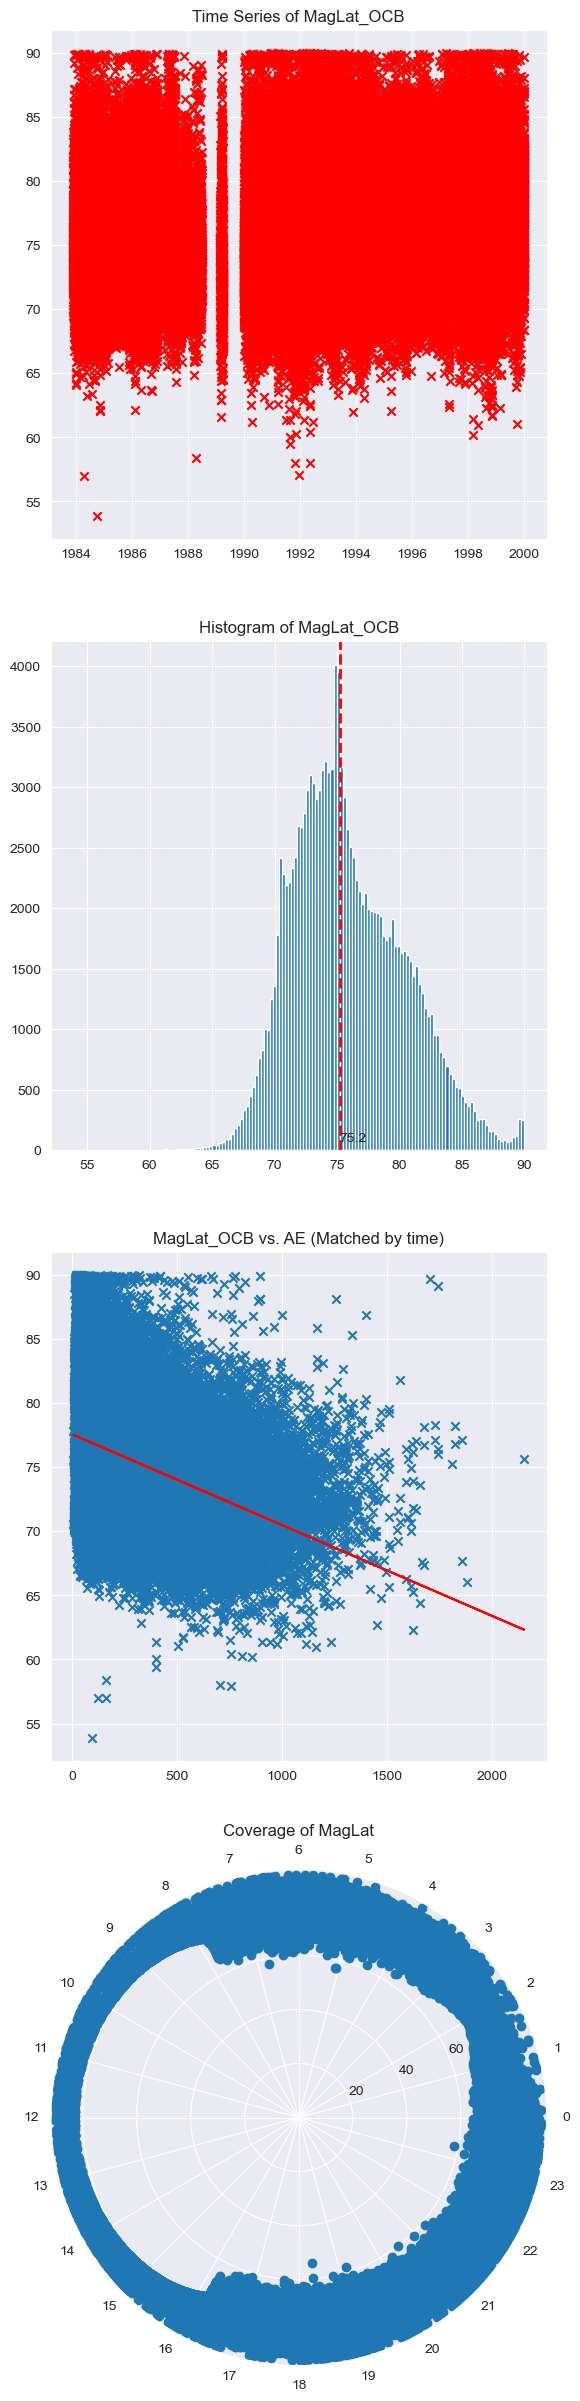

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# # # # # # # # # # # # # # # # # # # #
#   Can Select any Date & Hemisphere  #
# # # # # # # # # # # # # # # # # # # #

# Change the specified time here
start_date = '1983-12-1'
end_date = '2002-1-30'

# Fixing some columns
merged_df['1-H_AE'] = merged_df['1-H_AE'].astype(float)

# Enter the parameters here
Hemi = merged_df['MagLat_OCB'] > 0 
Time = (merged_df['Date_UTC'] >= start_date) & (merged_df['Date_UTC'] <= end_date)
AE_index = (merged_df['1-H_AE'] < 9998) 

Hemi_merged_df = merged_df[Hemi & Time & AE_index]

# Extract the data you need
X = Hemi_merged_df['Date_UTC']
Y = Hemi_merged_df['MagLat_OCB']
MLT_theta = (Hemi_merged_df['MLT_OCB']/12 * np.pi)
AE = Hemi_merged_df['1-H_AE'].astype(int)

### Plots
plt.subplot(4,1,1)
plt.scatter(X, Y, marker='x', color='red')
plt.title('Time Series of MagLat_OCB')

plt.subplot(4,1,2)
plt.title('Histogram of MagLat_OCB')
median = np.median(Y)
plt.hist(Y, bins='auto')
plt.axvline(median, color='red', linestyle='dashed', linewidth=2, label='Median')
plt.annotate(str(median), xy=(median, median))

plt.subplot(4,1,3)
plt.title('MagLat_OCB vs. AE (Matched by time)')
plt.scatter(AE, Y, marker='x')
slope , intercept = np.polyfit(AE, Y, 1)
plt.plot(AE, slope * AE + intercept, color='red')
# plt.xticks(np.arange(0, 1500, 100))

plt.subplot(4,1,4, polar = True)
plt.scatter(MLT_theta, Y)
# Customize labels
angles = np.linspace(0, 2*np.pi, 24, endpoint=False)
labels = [t for t in range(0,24)]
plt.xticks(angles, labels)
plt.title('Coverage of MagLat')

plt.subplots_adjust(wspace=1, bottom = -4)

# plt.polar(X, MLT, angle='xy')

Can see that currently it is all Nightside data, dayside data is incoming

Epoch 1/10


/Users/beastxgamer/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2763/2763 ━━━━━━━━━━━━━━━━━━━━ 2s 517us/step - loss: 0.0321 - mae: 0.1258 - val_loss: 0.0133 - val_mae: 0.0941
Epoch 2/10
2763/2763 ━━━━━━━━━━━━━━━━━━━━ 1s 478us/step - loss: 0.0131 - mae: 0.0929 - val_loss: 0.0134 - val_mae: 0.0932
Epoch 3/10
2763/2763 ━━━━━━━━━━━━━━━━━━━━ 1s 516us/step - loss: 0.0132 - mae: 0.0931 - val_loss: 0.0133 - val_mae: 0.0937
Epoch 4/10
2763/2763 ━━━━━━━━━━━━━━━━━━━━ 1s 458us/step - loss: 0.0131 - mae: 0.0924 - val_loss: 0.0133 - val_mae: 0.0930
Epoch 5/10
2763/2763 ━━━━━━━━━━━━━━━━━━━━ 1s 441us/step - loss: 0.0131 - mae: 0.0928 - val_loss: 0.0133 - val_mae: 0.0936
Epoch 6/10
2763/2763 ━━━━━━━━━━━━━━━━━━━━ 1s 438us/step - loss: 0.0131 - mae: 0.0928 - val_loss: 0.0133 - val_mae: 0.0939
Epoch 7/10
2763/2763 ━━━━━━━━━━━━━━━━━━━━ 1s 425us/step - loss: 0.0131 - mae: 0.0927 - val_loss: 0.0132 - val_mae: 0.0933
Epoch 8/10
2763/2763 ━━━━━━━━━━━━━━━━━━━━ 1s 410us/step - loss: 0.0131 - mae: 0.0927 - val_loss: 0.0132 - val_mae: 0.0933
Epoch 9/10
2763/2763 ━━━━━━━━━━━━━━

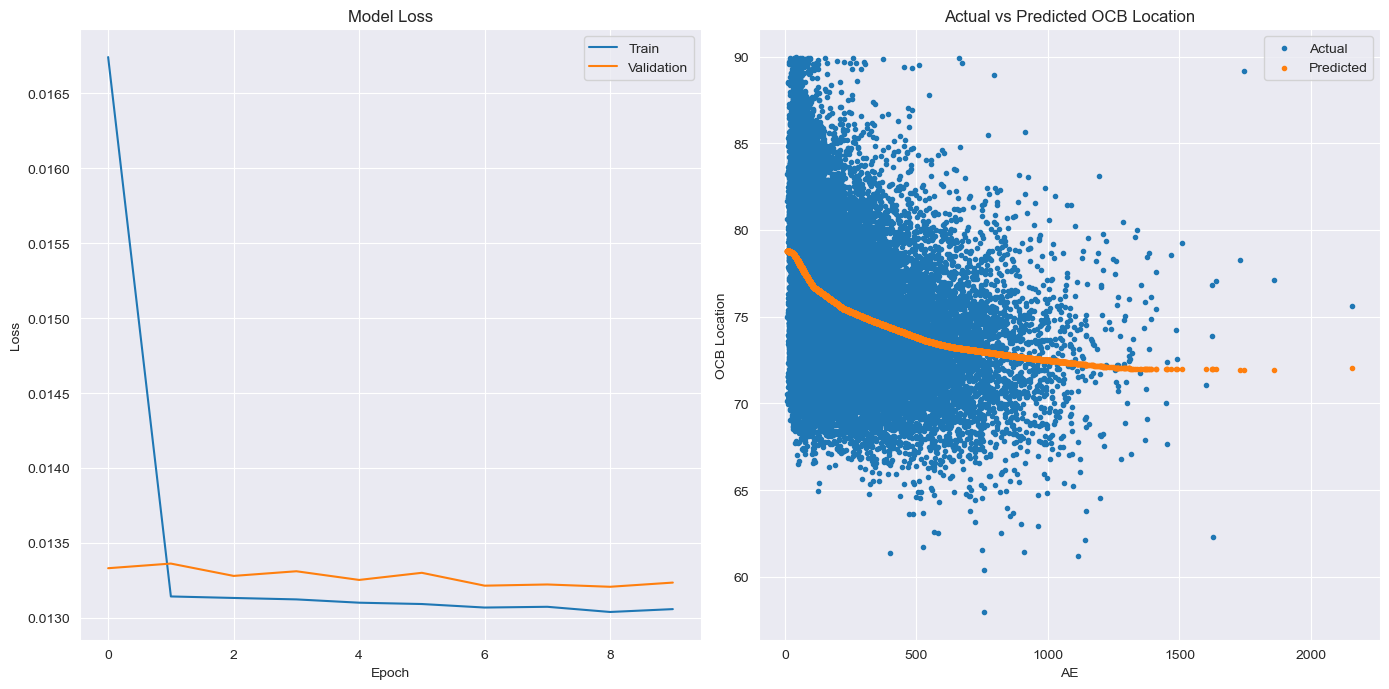

In [10]:
### The previous NN model, for only AE and OCB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# Normalize the input features
X = Hemi_merged_df[['1-H_AE']].astype(float).values
Y = Hemi_merged_df['MagLat_OCB'].astype(float).values

input_scaler = MinMaxScaler()
X = input_scaler.fit_transform(X) # AE as condition

# Normalize the target variable
output_scaler = MinMaxScaler()
y = output_scaler.fit_transform(Y.reshape(-1, 1)).flatten()

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the neural network model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model, choose 10 epochs, because loss and mae values stabilize after like 2
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test MAE: {test_mae}')

# Make predictions
predictions = model.predict(X_test)

# Inverse transform predictions to original scale
predictions_rescaled = output_scaler.inverse_transform(predictions)

# Print the first 10 predictions
print(predictions_rescaled[:10])

# Plot training & validation loss values
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot predictions vs actual values
plt.subplot(1, 2, 2)
plt.scatter(input_scaler.inverse_transform(X_test), output_scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual', marker = '.')
plt.scatter(input_scaler.inverse_transform(X_test), predictions_rescaled, label='Predicted', marker = '.')
plt.title('Actual vs Predicted OCB Location')
plt.xlabel('AE')
plt.ylabel('OCB Location')
plt.legend()

plt.tight_layout()
plt.show()

## Now let's try adding more variables
First we have to clean up some of the data, by imposing some conditions

In [11]:
merged_df.head(8)

,Date_UTC,MagLat_OCB,MLT_OCB,MagLat_B2I,MLT_B2I,"1AU_IP_BX,_GSE","1AU_IP_BY,_GSE","1AU_IP_BZ,_GSE",1AU_IP_PLASMA_SPEED,3-H_KP*10,1-H_DST,1-H_AE,1-H_AL-INDEX,AU-INDEX,PROTON_QI
0,1983-12-01 00:19:30,76.39,4.01,65.21,0.40,999.900,999.900,999.900,9999.00,33,-17,206.0,-126,79,9.9999
1,1983-12-01 00:30:42,-78.71,18.37,-67.17,18.26,999.900,999.900,999.900,9999.00,33,-17,206.0,-126,79,9.9999
2,1983-12-01 00:38:35,-75.03,5.90,-69.69,5.97,999.900,999.900,999.900,9999.00,33,-17,206.0,-126,79,9.9999
3,1983-12-01 01:09:11,-73.41,19.42,-65.60,20.31,999.900,999.900,999.900,9999.00,33,-19,309.0,-178,130,9.9999
4,1983-12-01 01:20:21,78.50,4.38,67.15,5.15,999.900,999.900,999.900,9999.00,33,-19,309.0,-178,130,9.9999
5,1983-12-01 01:28:52,73.51,18.94,65.74,18.58,999.900,999.900,999.900,9999.00,33,-19,309.0,-178,130,9.9999
6,1983-12-01 02:10:01,-75.96,19.53,-65.79,18.99,999.900,999.900,999.900,9999.00,33,-21,293.0,-139,154,9.9999
7,1983-12-01 02:17:30,-77.62,4.77,-67.25,5.56,999.900,999.900,999.900,9999.00,33,-21,293.0,-139,154,9.9999


### Selection of Data for Analysis
Below we can find the dataframe being transformed into another dataframe, called main_df, which I will use to build the model. Below we can change and of the conditions to suite our needs.

In [23]:
#merged_df['1AU_IP_BX,_GSE'] = merged_df['1AU_IP_BX,_GSE'].astype(float)
#merged_df['1AU_IP_BY,_GSE'] = merged_df['1AU_IP_BY,_GSE'].astype(float)
#merged_df['1AU_IP_BZ,_GSE'] = merged_df['1AU_IP_BZ,_GSE'].astype(float)
#merged_df['1AU_IP_PLASMA_SPEED'] = merged_df['1AU_IP_PLASMA_SPEED'].astype(float)
#merged_df['PROTON_QI'] = merged_df['PROTON_QI'].astype(float)
merged_df.iloc[:, 1:] = merged_df.iloc[:, 1:].astype(float)

### Conditioning the dataframe to select for true values

Hemisphere = merged_df['MagLat_OCB'] > 0 
bad = merged_df['MagLat_OCB'] < 85             # Northern or Southern
AE_1 = merged_df['1-H_AE'] < 9998
Bx = merged_df['1AU_IP_BX,_GSE'] < 998
By = merged_df['1AU_IP_BY,_GSE'] < 998
Bz = merged_df['1AU_IP_BZ,_GSE'] < 998
PlasmaSpeed = merged_df['1AU_IP_PLASMA_SPEED'] < 9998
proton = merged_df['PROTON_QI'] < 9.998
mlt = merged_df['MLT_OCB'] > 16 

main_df = merged_df[Hemisphere & AE_1 & Bx & By & Bz & PlasmaSpeed & proton & mlt & bad]

main_df.head(10)
# print(main_df.shape) # still 108,000+ points

,Date_UTC,MagLat_OCB,MLT_OCB,MagLat_B2I,MLT_B2I,"1AU_IP_BX,_GSE","1AU_IP_BY,_GSE","1AU_IP_BZ,_GSE",1AU_IP_PLASMA_SPEED,3-H_KP*10,1-H_DST,1-H_AE,1-H_AL-INDEX,AU-INDEX,PROTON_QI
184,1983-12-05 01:43:50,78.99,19.25,68.49,18.55,-5.0,7.8,1.5,393.0,30.0,17.0,55.0,-28.0,25.0,0.0301
190,1983-12-05 03:23:29,81.59,18.54,66.65,18.24,-6.6,2.5,-5.7,396.0,33.0,-1.0,320.0,-260.0,59.0,0.0316
196,1983-12-05 05:05:20,75.52,18.37,66.18,18.41,-5.4,9.0,0.2,421.0,33.0,1.0,241.0,-149.0,91.0,0.0315
198,1983-12-05 05:50:38,73.32,22.96,64.27,22.67,-5.4,9.0,0.2,421.0,33.0,1.0,241.0,-149.0,91.0,0.0315
202,1983-12-05 06:46:34,71.92,18.86,64.35,18.87,-6.3,8.5,-0.3,428.0,30.0,1.0,297.0,-193.0,103.0,0.0307
204,1983-12-05 07:30:30,74.64,22.49,68.07,22.43,-7.0,7.9,-2.3,426.0,30.0,6.0,418.0,-252.0,164.0,0.0282
222,1983-12-05 15:11:53,71.12,21.68,65.23,20.62,-6.0,11.0,0.8,437.0,33.0,5.0,499.0,-383.0,115.0,0.0298
224,1983-12-05 16:52:57,72.38,22.06,63.70,20.37,-7.6,8.8,0.9,454.0,33.0,5.0,433.0,-312.0,119.0,0.0331
233,1983-12-05 23:39:54,80.13,22.04,66.55,19.43,-6.3,11.6,-0.6,465.0,37.0,-7.0,200.0,-101.0,97.0,0.0542
262,1983-12-06 08:50:25,75.82,22.35,62.99,22.38,-7.4,3.7,-2.1,618.0,47.0,-19.0,433.0,-293.0,138.0,0.0254


Ok, so now we got the data cleared of any placeholder, we can begin to do some analysis. Let's start off with a straightforward Linear Regression.

In [21]:
main_df.describe()

,Date_UTC,MagLat_OCB,MLT_OCB,MagLat_B2I,MLT_B2I,1-H_AE,PROTON_QI
count,67204,67204.000000,67204.000000,67204.000000,67204.000000,67204.000000,67204.000000
mean,1998-05-26 10:03:18.468320384,75.799829,18.718847,67.384581,19.155180,209.487739,0.018974
min,1983-12-05 01:43:50,59.450000,12.010000,40.910000,1.540000,3.000000,0.000100
25%,1994-03-07 13:52:40.250000,72.450000,17.090000,65.460000,17.980000,56.000000,0.007900
50%,1997-09-06 19:23:46.500000,75.440000,18.470000,67.490000,19.120000,131.000000,0.012900
75%,2006-06-12 17:40:15.750000,79.080000,20.480000,69.380000,20.340000,298.000000,0.021500
max,2009-12-31 14:52:11,84.990000,24.000000,85.470000,23.780000,2155.000000,0.860300
std,NaN,4.198675,2.256675,3.093924,1.880886,210.211226,0.025495


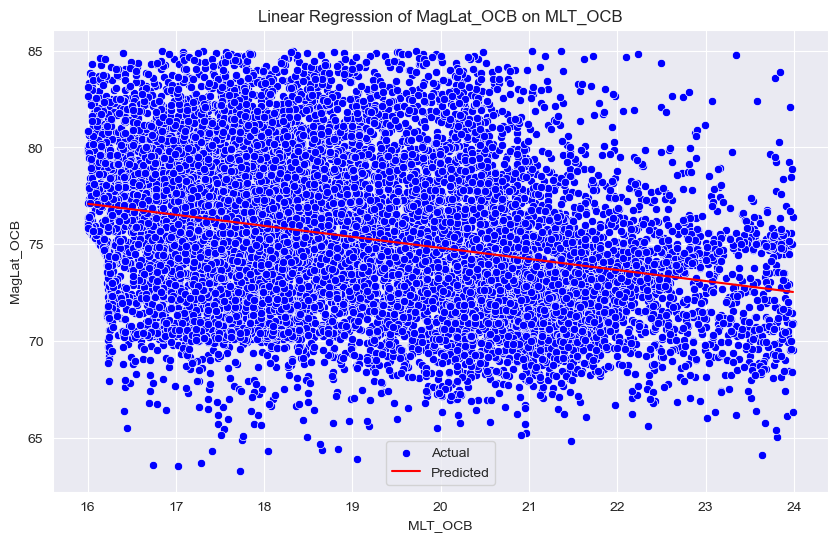

R² for MagLat_OCB on MLT_OCB: 0.0748
MSE for MagLat_OCB on MLT_OCB: 14.9453



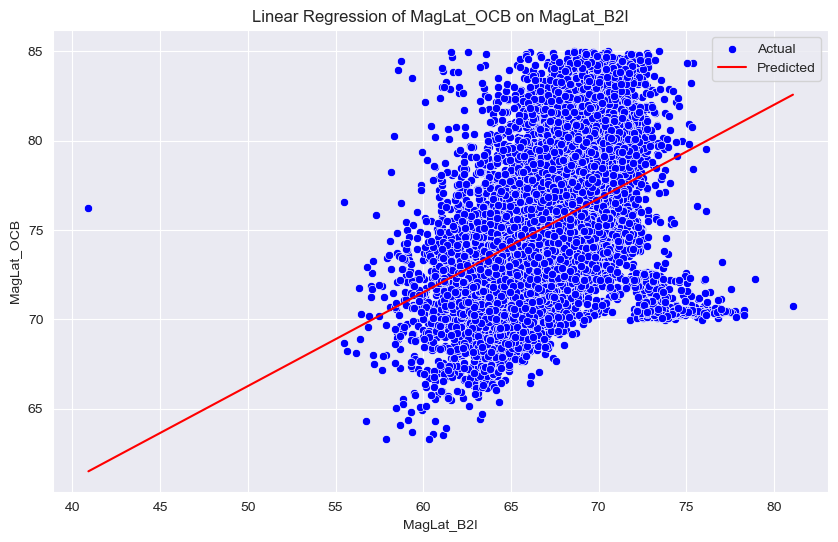

R² for MagLat_OCB on MagLat_B2I: 0.1613
MSE for MagLat_OCB on MagLat_B2I: 13.5484



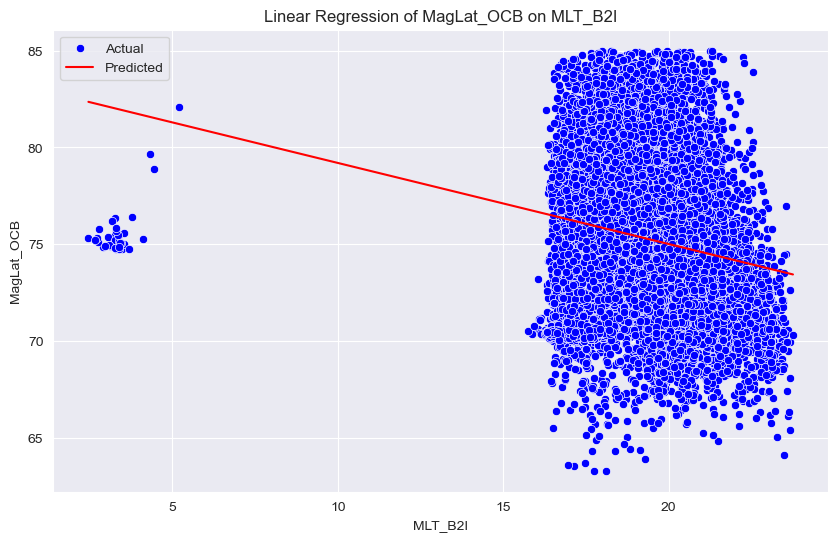

R² for MagLat_OCB on MLT_B2I: 0.0358
MSE for MagLat_OCB on MLT_B2I: 15.5754



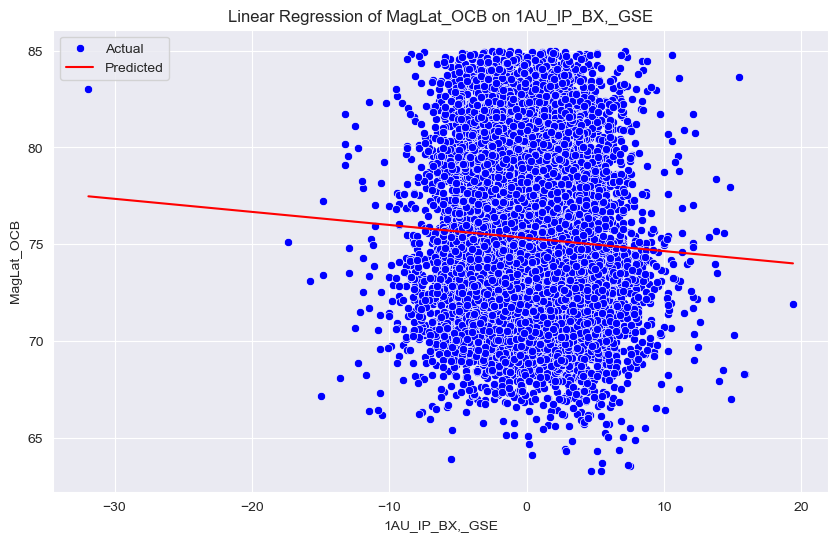

R² for MagLat_OCB on 1AU_IP_BX,_GSE: 0.0031
MSE for MagLat_OCB on 1AU_IP_BX,_GSE: 16.1044



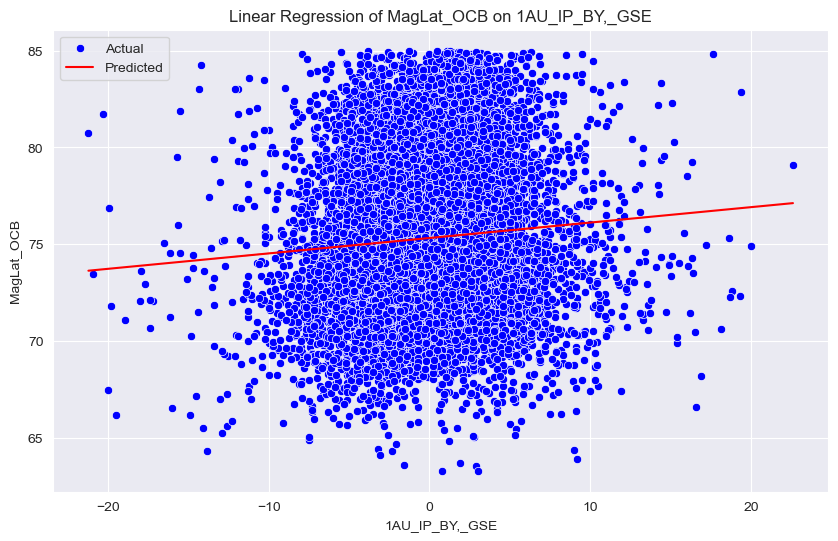

R² for MagLat_OCB on 1AU_IP_BY,_GSE: 0.0043
MSE for MagLat_OCB on 1AU_IP_BY,_GSE: 16.0849



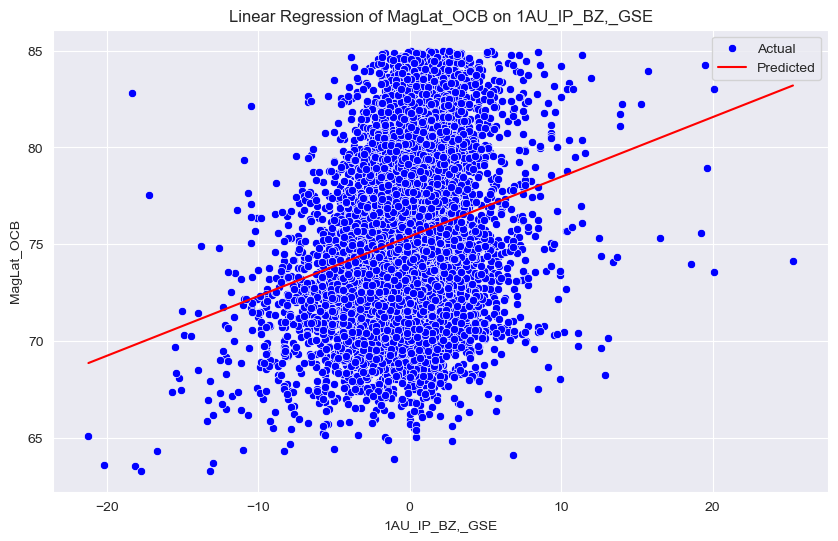

R² for MagLat_OCB on 1AU_IP_BZ,_GSE: 0.0539
MSE for MagLat_OCB on 1AU_IP_BZ,_GSE: 15.2833



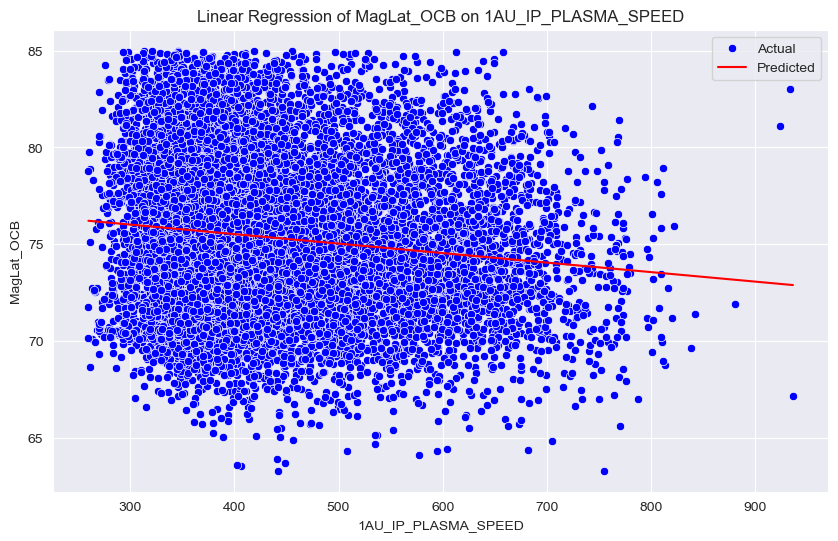

R² for MagLat_OCB on 1AU_IP_PLASMA_SPEED: 0.0125
MSE for MagLat_OCB on 1AU_IP_PLASMA_SPEED: 15.9513



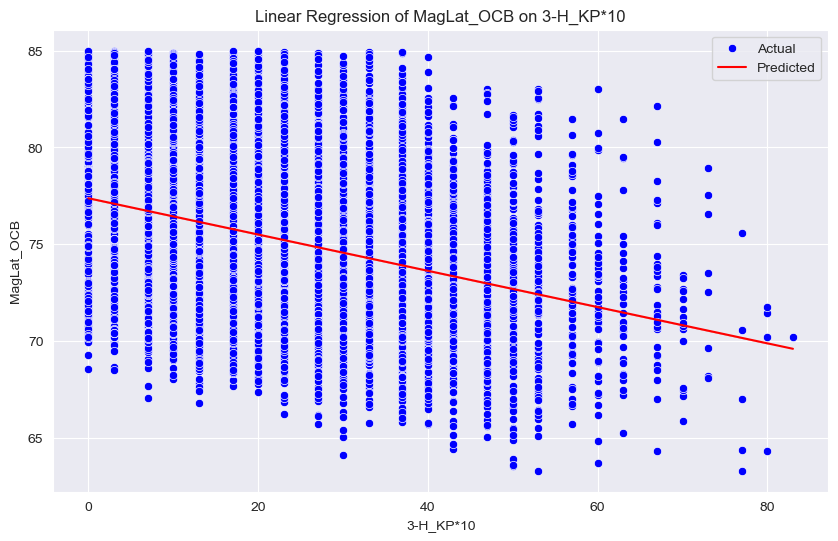

R² for MagLat_OCB on 3-H_KP*10: 0.1022
MSE for MagLat_OCB on 3-H_KP*10: 14.5035



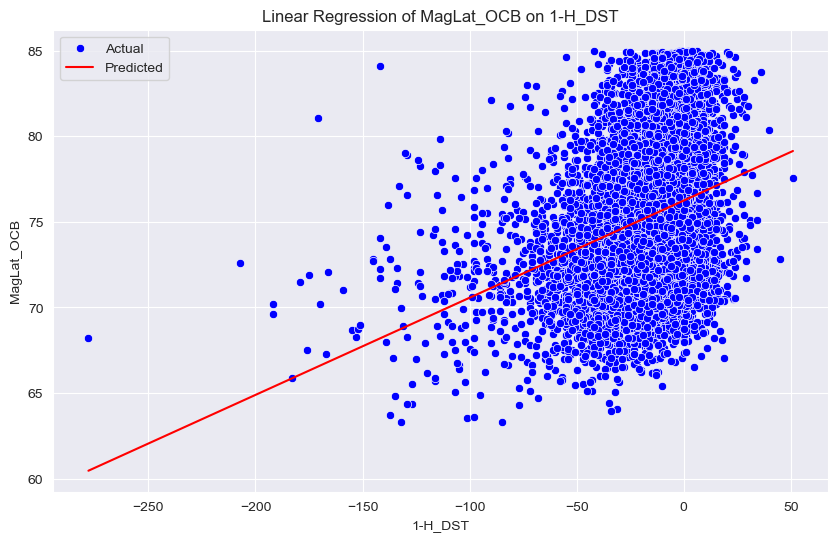

R² for MagLat_OCB on 1-H_DST: 0.0838
MSE for MagLat_OCB on 1-H_DST: 14.8008


Ranking by R²:
  Dependent Variable Independent Variable        R²        MSE
0         MagLat_OCB           MagLat_B2I  0.161283  13.548415
1         MagLat_OCB            3-H_KP*10  0.102161  14.503458
2         MagLat_OCB              1-H_DST  0.083751  14.800839
3         MagLat_OCB              MLT_OCB  0.074811  14.945255
4         MagLat_OCB       1AU_IP_BZ,_GSE  0.053884  15.283310
5         MagLat_OCB              MLT_B2I  0.035800  15.575429
6         MagLat_OCB  1AU_IP_PLASMA_SPEED  0.012532  15.951295
7         MagLat_OCB       1AU_IP_BY,_GSE  0.004262  16.084878
8         MagLat_OCB       1AU_IP_BX,_GSE  0.003055  16.104381

Ranking by MSE:
  Dependent Variable Independent Variable        R²        MSE
0         MagLat_OCB           MagLat_B2I  0.161283  13.548415
1         MagLat_OCB            3-H_KP*10  0.102161  14.503458
2         MagLat_OCB              1-H_DST  0.083751  14.800839
3       

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

# Defining dependent variable as everything not maglat_OCB and independent variables as those related to OCB
dependent_vars = main_df.columns[1:2]
independent_vars = main_df.columns[2:11]

### Function to do Linear Regression
def linear_regression_analysis(df, dep_var, ind_var):
    X = df[[ind_var]].values
    y = df[dep_var].values

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict on test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    # Create plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=X_test.flatten(), y=y_test, color='blue', label='Actual')
    sns.lineplot(x=X_test.flatten(), y=y_pred, color='red', label='Predicted')
    plt.title(f'Linear Regression of {dep_var} on {ind_var}')
    plt.xlabel(ind_var)
    plt.ylabel(dep_var)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Return metrics for ranking
    return r2, mse

# Store results for ranking
results = []

# Perform linear regression for each independent variable against each dependent variable
for dep_var in dependent_vars:
    for ind_var in independent_vars:
        r2, mse = linear_regression_analysis(main_df, dep_var, ind_var)
        results.append((dep_var, ind_var, r2, mse))
        print(f'R² for {dep_var} on {ind_var}: {r2:.4f}')
        print(f'MSE for {dep_var} on {ind_var}: {mse:.4f}\n')
### Analysis
# Convert results to DataFrame for easy sorting
results_df = pd.DataFrame(results, columns=['Dependent Variable', 'Independent Variable', 'R²', 'MSE'])

# Rank by R² (higher is better)
ranked_by_r2 = results_df.sort_values(by='R²', ascending=False).reset_index(drop=True)
print("\nRanking by R²:")
print(ranked_by_r2)

# Rank by MSE (lower is better)
ranked_by_mse = results_df.sort_values(by='MSE', ascending=True).reset_index(drop=True)
print("\nRanking by MSE:")
print(ranked_by_mse)


### Results from Linear Regression
After the results of the simple linear regression, we see that the model does pretty badly, and the best predictors of OCB are b2i (which makes sense as I assume they may be coupled?), the 3-H KP, 1-H DST, and the BZ, which are all expected. The worst models are the ones where I did not try to change anything, so it came out as pretty bad (MLT_OCB and BY, BX, etc.)

### Onto the Neural Network (Using tensorflow for now)

Epoch 1/100


/Users/beastxgamer/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 722us/step - loss: 325.9445 - mse: 325.9445 - val_loss: 143.7826 - val_mse: 143.7826
Epoch 2/100
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 1s 633us/step - loss: 36.1408 - mse: 36.1408 - val_loss: 184.3163 - val_mse: 184.3163
Epoch 3/100
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 1s 700us/step - loss: 29.7955 - mse: 29.7955 - val_loss: 167.5571 - val_mse: 167.5571
Epoch 4/100
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 1s 661us/step - loss: 25.7055 - mse: 25.7055 - val_loss: 242.3865 - val_mse: 242.3865
Epoch 5/100
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 1s 713us/step - loss: 23.7560 - mse: 23.7560 - val_loss: 138.4595 - val_mse: 138.4595
Epoch 6/100
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 1s 711us/step - loss: 22.6135 - mse: 22.6135 - val_loss: 192.2545 - val_mse: 192.2545
Epoch 7/100
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 1s 634us/step - loss: 21.0396 - mse: 21.0396 - val_loss: 257.3704 - val_mse: 257.3704
Epoch 8/100
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 21.1975 - mse: 21.1975 - val_loss: 239.2505 

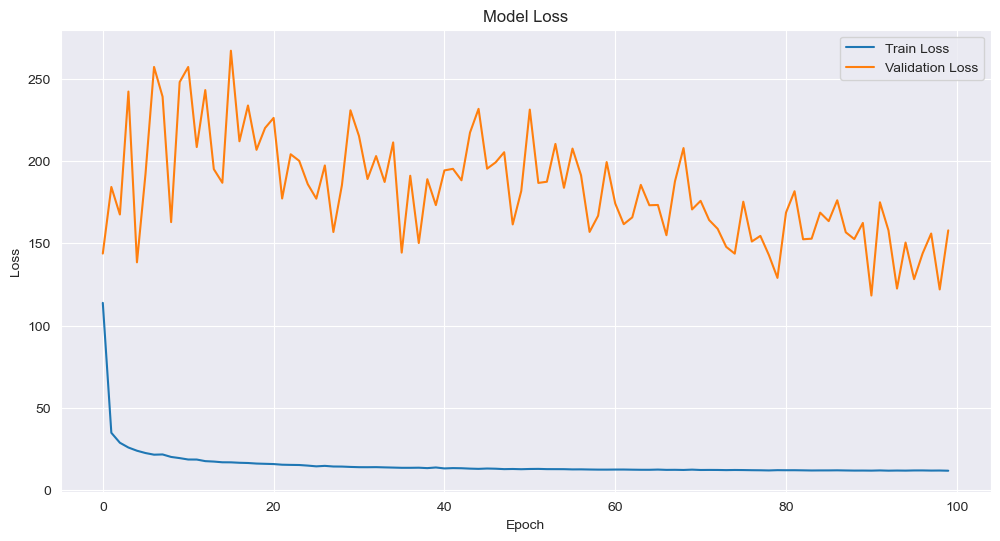

In [15]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Independent variables: columns 3 to 11 (0-indexed 2 to 10)
X = main_df.iloc[:, 2:11].values.astype(np.float32)

# Dependent variables: columns 2 (0-indexed 1)
y = main_df.iloc[:, 1:2].values.astype(np.float32)

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(y_train.shape[1]))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, mse = model.evaluate(X_test, y_test)

print("Test Loss:", loss)
print("Test Mean Squared Error:", mse)

# Predict on test data
y_pred = model.predict(X_test)

# Calculating additional metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R^2: {r2:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Mean Squared Error: {mse:.4f}")

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


### Analysis
Our first attempt at a neural network with all the data did not prove to be so great, the R^2 value is <0.5 which is not great. Now let's take a look at the features.

In [16]:
# Get weights of the first hidden layer
first_layer_weights = model.layers[0].get_weights()[0]

# Calculate the mean absolute weight for each feature
feature_importance = np.mean(np.abs(first_layer_weights), axis=1)
# Get feature names
feature_names = main_df.columns[2:]
# Combine feature names with their importances
importance_dict = {name: importance for name, importance in zip(feature_names, feature_importance)}
# Sort features by importance
sorted_importance = sorted(importance_dict.items(), key=lambda item: item[1], reverse=True)
# Print out the sorted feature importance
for feature, importance in sorted_importance:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: MLT_B2I, Importance: 0.47213056683540344
Feature: MLT_OCB, Importance: 0.2909287214279175
Feature: 1AU_IP_BZ,_GSE, Importance: 0.22483019530773163
Feature: 1AU_IP_BX,_GSE, Importance: 0.20889993011951447
Feature: MagLat_B2I, Importance: 0.20627892017364502
Feature: 1AU_IP_BY,_GSE, Importance: 0.15530642867088318
Feature: 3-H_KP*10, Importance: 0.13794495165348053
Feature: 1-H_DST, Importance: 0.13554051518440247
Feature: 1AU_IP_PLASMA_SPEED, Importance: 0.08470951020717621


Interesting, Bx and Plasma Speed's importance does not match with what we understand with the Linear Regression analysis. Let's take a look at other forms of feature rankings

### Permutation Feature Importance
shuffling the features randomly to see which one makes the model better

In [17]:
from sklearn.metrics import mean_squared_error
# Define a function to calculate permutation importance
def permutation_importance(model, X, y, metric=mean_squared_error):
    baseline = metric(y, model.predict(X))
    importances = []

    for i in range(X.shape[1]):
        X_permuted = X.copy()
        np.random.shuffle(X_permuted[:, i])
        score = metric(y, model.predict(X_permuted))
        importances.append(baseline - score)

    return importances

# Calculate permutation importance
X_test_array = X_test
y_test_array = y_test

importances = permutation_importance(model, X_test_array, y_test_array)

# Display feature importances
for name, importance in zip(feature_names, importances):
    print(f"Feature: {name}, Importance: {importance}")

446/446 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step
446/446 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step
446/446 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
446/446 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
446/446 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step
446/446 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step
446/446 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
446/446 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
446/446 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step
446/446 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step
Feature: MLT_OCB, Importance: 6.8868560791015625
Feature: MagLat_B2I, Importance: 0.2752532958984375
Feature: MLT_B2I, Importance: 17.42926025390625
Feature: 1AU_IP_BX,_GSE, Importance: -0.484832763671875
Feature: 1AU_IP_BY,_GSE, Importance: -0.701812744140625
Feature: 1AU_IP_BZ,_GSE, Importance: -0.73345947265625
Feature: 1AU_IP_PLASMA_SPEED, Importance: 2.3925628662109375
Feature: 3-H_KP*10, Importance: 2.175994873046875
Feature: 1-H_DST, Importance: 2.2600250244140625


### Results from Permuation Feature Importance
Again it seems that Bx has the highest importance, as when the feature is shuffled the model gets better when it is used. The other features seem to be less important, as magnitude of shift is 32x less.

### Now let's see what SHAP (SHapley Additive exPlanations) says 

In [18]:
import shap

X_train_array = X_train

# Summarize the background data using K-means
K = 100
background_data_reduced = shap.kmeans(X_train_array, K)

# Create a SHAP explainer with the summarized background data
explainer = shap.KernelExplainer(model.predict, background_data_reduced)

# Calculate SHAP values for a sample
shap_values = explainer.shap_values(X_train_array[:100])  # Sample first 100

# Plot SHAP values
shap.summary_plot(shap_values, X_train_array[:100], feature_names=feature_names)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 1s 308us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 1s 316us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 1s 317us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 1s 314us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
1/1 ━━━━━━━━━━━

KeyboardInterrupt: 

In [ ]:
merged_df.to_csv('alldata.csv', index=False)